In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Adam = optimizers.Adam(lr=0.001)

In [2]:
csv_path_train = 'testset/J0003_0024_0221_20110307012732_cell_20.csv'
csv_path_test = 'testset/J0003_0024_0221_20110307012732_cell_03.csv'
df = pd.read_csv(csv_path_train)
df_test = pd.read_csv(csv_path_test)

date_time = pd.to_datetime(df.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')
date_time_test = pd.to_datetime(df_test.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')

In [3]:
df.head()

,CellNo,Resistance,Volt,Temp
0,20,0.271,2.24,-20
1,20,0.271,2.24,-20
2,20,0.271,2.24,-20
3,20,0.271,2.24,-20
4,20,0.270,2.24,-20


In [4]:
df_test.head()

,CellNo,Resistance,Volt,Temp
0,3,0.298,2.23,-20
1,3,0.298,2.23,-20
2,3,0.297,2.24,-20
3,3,0.299,2.23,-20
4,3,0.298,2.24,-20


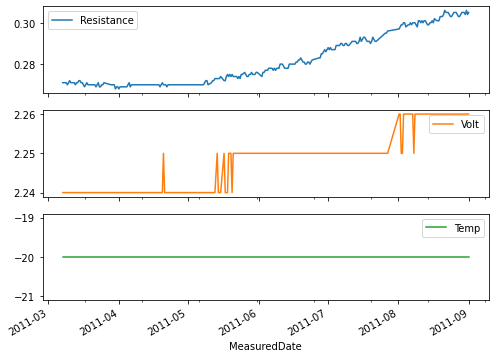

In [5]:
plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


array([<AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>], dtype=object)

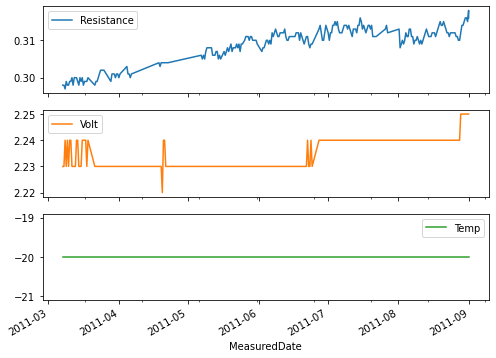

In [6]:
#plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features_test = df_test[plot_cols]
plot_features_test.index = date_time_test
plot_features_test.plot(subplots=True)

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CellNo,252.0,20.000000,0.000000,20.000,20.000,20.00,20.0000,20.000
Resistance,252.0,0.283746,0.012299,0.268,0.272,0.28,0.2935,0.306
Volt,252.0,2.249405,0.007144,2.240,2.240,2.25,2.2500,2.260
Temp,252.0,-20.000000,0.000000,-20.000,-20.000,-20.00,-20.0000,-20.000


In [8]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices = {name: i for i, name in enumerate(df_test.columns)}

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
df = scaler.fit_transform(df[plot_cols])
df_test = scaler.fit_transform(df_test[plot_cols])
df = pd.DataFrame(df)
df_test = pd.DataFrame(df_test)
df.columns = plot_cols
df_test.columns = plot_cols

In [10]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.8)]
test_df = df[int(n*0.8):]
#n_test = len(df_test)
test_df_test = df_test[:int(n*0.7)]
label_df = df_test[int(n*0.7):]

num_features = df.shape[1]
#print(int(n*0.8),int(n*0.2),len(test_df), len(label_df))

In [11]:
df.head()

,Resistance,Volt,Temp
0,0.078947,0.0,0.0
1,0.078947,0.0,0.0
2,0.078947,0.0,0.0
3,0.078947,0.0,0.0
4,0.052632,0.0,0.0


<AxesSubplot:>

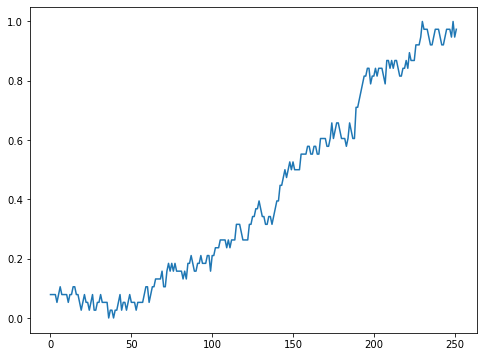

In [12]:
df['Resistance'].plot()

In [13]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

    # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [14]:
#w1 = WindowGenerator(input_width = 28, label_width=28, shift=1, label_columns = ['Resistance'])
#w1

In [15]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
def plot(self, model=None, plot_col='Resistance', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    max_n=1
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.plot(self.label_indices, labels[n, :, label_col_index], label='Labels', c='#2ca02c', zorder=-10)
                #edgecolors='k', c='#2ca02c', s=1)
        if model is not None:
            predictions = model(inputs)
            plt.plot(self.label_indices, predictions[n, :, label_col_index], label='Predictions', c='#ff7f0e', zorder=-10)
                   
             #           edgecolors='k', label='Predictions',
              #    c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [17]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets = None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

In [18]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

def test_test(self):
    return self.make_dataset(self.test_df_test)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
    # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.test_test = test_test

Total window size: 174
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]
Label indices: [150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173]
Label column name(s): None

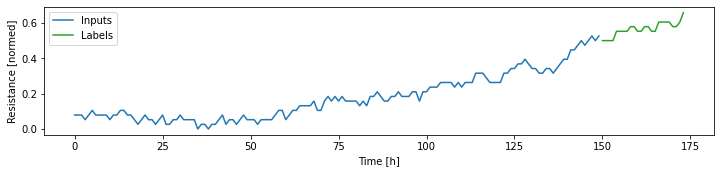

In [19]:
OUT_STEPS = 24

multi_window = WindowGenerator(input_width=150,
                              label_width=OUT_STEPS,
                              shift=OUT_STEPS)

multi_window.plot()
multi_window

In [20]:
MAX_EPOCHS = 1500

def compile_and_fit(model, window, patience=500):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                    # optimizer=tf.optimizers.Adam(),
                    optimizer=Adam,
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [21]:
model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # tf.keras.layers.LSTM(32, activation='relu', kernel_initializer='he_normal', dropout=0.1, return_sequences=False),
    # tf.keras.layers.Dropout(rate=0.2),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [22]:
history = compile_and_fit(model, multi_window)

Epoch 1/1500
1/1 [==============================] - 4s 4s/step - loss: 0.1904 - mean_absolute_error: 0.3551
Epoch 2/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.1878 - mean_absolute_error: 0.3528
Epoch 3/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.1852 - mean_absolute_error: 0.3502
Epoch 4/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.1823 - mean_absolute_error: 0.3475
Epoch 5/1500
1/1 [==============================] - 0s 109ms/step - loss: 0.1791 - mean_absolute_error: 0.3445
Epoch 6/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.1757 - mean_absolute_error: 0.3411
Epoch 7/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.1720 - mean_absolute_error: 0.3375
Epoch 8/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.1679 - mean_absolute_error: 0.3334
Epoch 9/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.1633 - mean_absolute_error: 0.3288
Epoch 10/1

Epoch 34/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.0065 - mean_absolute_error: 0.0635
Epoch 35/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0071 - mean_absolute_error: 0.0673
Epoch 36/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.0073 - mean_absolute_error: 0.0685
Epoch 37/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.0070 - mean_absolute_error: 0.0673
Epoch 38/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.0063 - mean_absolute_error: 0.0643
Epoch 39/1500
1/1 [==============================] - 0s 95ms/step - loss: 0.0054 - mean_absolute_error: 0.0597
Epoch 40/1500
1/1 [==============================] - 0s 105ms/step - loss: 0.0045 - mean_absolute_error: 0.0540
Epoch 41/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0035 - mean_absolute_error: 0.0474
Epoch 42/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0025 - mean_absolute_error: 0.0403


1/1 [==============================] - 0s 111ms/step - loss: 1.3026e-04 - mean_absolute_error: 0.0072
Epoch 67/1500
1/1 [==============================] - 0s 103ms/step - loss: 9.9795e-05 - mean_absolute_error: 0.0055
Epoch 68/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.7466e-05 - mean_absolute_error: 0.0043
Epoch 69/1500
1/1 [==============================] - 0s 102ms/step - loss: 9.0089e-05 - mean_absolute_error: 0.0055
Epoch 70/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.0363e-04 - mean_absolute_error: 0.0067
Epoch 71/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.2371e-04 - mean_absolute_error: 0.0079
Epoch 72/1500
1/1 [==============================] - 0s 96ms/step - loss: 1.4609e-04 - mean_absolute_error: 0.0088
Epoch 73/1500
1/1 [==============================] - 0s 96ms/step - loss: 1.6706e-04 - mean_absolute_error: 0.0095
Epoch 74/1500
1/1 [==============================] - 0s 99ms/step - loss: 1.8377e-04 - me

1/1 [==============================] - 0s 96ms/step - loss: 9.5055e-05 - mean_absolute_error: 0.0059
Epoch 99/1500
1/1 [==============================] - 0s 102ms/step - loss: 9.2475e-05 - mean_absolute_error: 0.0057
Epoch 100/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.9921e-05 - mean_absolute_error: 0.0054
Epoch 101/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.7629e-05 - mean_absolute_error: 0.0052
Epoch 102/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.5772e-05 - mean_absolute_error: 0.0049
Epoch 103/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.4444e-05 - mean_absolute_error: 0.0046
Epoch 104/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3663e-05 - mean_absolute_error: 0.0044
Epoch 105/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3382e-05 - mean_absolute_error: 0.0041
Epoch 106/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3503e-0

Epoch 130/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.3638e-05 - mean_absolute_error: 0.0043
Epoch 131/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3584e-05 - mean_absolute_error: 0.0043
Epoch 132/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3511e-05 - mean_absolute_error: 0.0043
Epoch 133/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3429e-05 - mean_absolute_error: 0.0042
Epoch 134/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3350e-05 - mean_absolute_error: 0.0042
Epoch 135/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.3281e-05 - mean_absolute_error: 0.0042
Epoch 136/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3229e-05 - mean_absolute_error: 0.0041
Epoch 137/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3196e-05 - mean_absolute_error: 0.0041
Epoch 138/1500
1/1 [==============================] - 0s 97ms/step -

1/1 [==============================] - 0s 102ms/step - loss: 8.3190e-05 - mean_absolute_error: 0.0040
Epoch 163/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3188e-05 - mean_absolute_error: 0.0040
Epoch 164/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3185e-05 - mean_absolute_error: 0.0040
Epoch 165/1500
1/1 [==============================] - 0s 107ms/step - loss: 8.3181e-05 - mean_absolute_error: 0.0040
Epoch 166/1500
1/1 [==============================] - 0s 109ms/step - loss: 8.3178e-05 - mean_absolute_error: 0.0040
Epoch 167/1500
1/1 [==============================] - 0s 106ms/step - loss: 8.3176e-05 - mean_absolute_error: 0.0040
Epoch 168/1500
1/1 [==============================] - 0s 111ms/step - loss: 8.3174e-05 - mean_absolute_error: 0.0040
Epoch 169/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3173e-05 - mean_absolute_error: 0.0040
Epoch 170/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.317

1/1 [==============================] - 0s 95ms/step - loss: 8.3173e-05 - mean_absolute_error: 0.0040
Epoch 195/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.3173e-05 - mean_absolute_error: 0.0040
Epoch 196/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3173e-05 - mean_absolute_error: 0.0040
Epoch 197/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3173e-05 - mean_absolute_error: 0.0040
Epoch 198/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3173e-05 - mean_absolute_error: 0.0040
Epoch 199/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.3173e-05 - mean_absolute_error: 0.0040
Epoch 200/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3173e-05 - mean_absolute_error: 0.0040
Epoch 201/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3173e-05 - mean_absolute_error: 0.0040
Epoch 202/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3173e-0

1/1 [==============================] - 0s 97ms/step - loss: 8.3172e-05 - mean_absolute_error: 0.0040
Epoch 227/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3172e-05 - mean_absolute_error: 0.0040
Epoch 228/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3172e-05 - mean_absolute_error: 0.0040
Epoch 229/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3172e-05 - mean_absolute_error: 0.0040
Epoch 230/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3172e-05 - mean_absolute_error: 0.0040
Epoch 231/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3172e-05 - mean_absolute_error: 0.0040
Epoch 232/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.3172e-05 - mean_absolute_error: 0.0040
Epoch 233/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3172e-05 - mean_absolute_error: 0.0040
Epoch 234/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3172e-0

1/1 [==============================] - 0s 98ms/step - loss: 8.3172e-05 - mean_absolute_error: 0.0040
Epoch 259/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3172e-05 - mean_absolute_error: 0.0040
Epoch 260/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3172e-05 - mean_absolute_error: 0.0040
Epoch 261/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3172e-05 - mean_absolute_error: 0.0040
Epoch 262/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3172e-05 - mean_absolute_error: 0.0040
Epoch 263/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3172e-05 - mean_absolute_error: 0.0040
Epoch 264/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3172e-05 - mean_absolute_error: 0.0040
Epoch 265/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3172e-05 - mean_absolute_error: 0.0040
Epoch 266/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3172e-

1/1 [==============================] - 0s 106ms/step - loss: 8.3171e-05 - mean_absolute_error: 0.0040
Epoch 291/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3171e-05 - mean_absolute_error: 0.0040
Epoch 292/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3171e-05 - mean_absolute_error: 0.0040
Epoch 293/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3171e-05 - mean_absolute_error: 0.0040
Epoch 294/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3171e-05 - mean_absolute_error: 0.0040
Epoch 295/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3171e-05 - mean_absolute_error: 0.0040
Epoch 296/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3171e-05 - mean_absolute_error: 0.0040
Epoch 297/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3171e-05 - mean_absolute_error: 0.0040
Epoch 298/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.317

1/1 [==============================] - 0s 92ms/step - loss: 8.3171e-05 - mean_absolute_error: 0.0040
Epoch 323/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3171e-05 - mean_absolute_error: 0.0040
Epoch 324/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3171e-05 - mean_absolute_error: 0.0040
Epoch 325/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.3171e-05 - mean_absolute_error: 0.0040
Epoch 326/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3171e-05 - mean_absolute_error: 0.0040
Epoch 327/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3171e-05 - mean_absolute_error: 0.0040
Epoch 328/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3171e-05 - mean_absolute_error: 0.0040
Epoch 329/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3171e-05 - mean_absolute_error: 0.0040
Epoch 330/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3171e-0

1/1 [==============================] - 0s 101ms/step - loss: 8.3171e-05 - mean_absolute_error: 0.0040
Epoch 355/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3171e-05 - mean_absolute_error: 0.0040
Epoch 356/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3170e-05 - mean_absolute_error: 0.0040
Epoch 357/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3171e-05 - mean_absolute_error: 0.0040
Epoch 358/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3171e-05 - mean_absolute_error: 0.0040
Epoch 359/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3171e-05 - mean_absolute_error: 0.0040
Epoch 360/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3170e-05 - mean_absolute_error: 0.0040
Epoch 361/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3170e-05 - mean_absolute_error: 0.0040
Epoch 362/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3170

1/1 [==============================] - 0s 92ms/step - loss: 8.3170e-05 - mean_absolute_error: 0.0040
Epoch 387/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3170e-05 - mean_absolute_error: 0.0040
Epoch 388/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3170e-05 - mean_absolute_error: 0.0040
Epoch 389/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3170e-05 - mean_absolute_error: 0.0040
Epoch 390/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3170e-05 - mean_absolute_error: 0.0040
Epoch 391/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3170e-05 - mean_absolute_error: 0.0040
Epoch 392/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3170e-05 - mean_absolute_error: 0.0040
Epoch 393/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3170e-05 - mean_absolute_error: 0.0040
Epoch 394/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.3170e-05

1/1 [==============================] - 0s 97ms/step - loss: 8.3170e-05 - mean_absolute_error: 0.0040
Epoch 419/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3170e-05 - mean_absolute_error: 0.0040
Epoch 420/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3169e-05 - mean_absolute_error: 0.0040
Epoch 421/1500
1/1 [==============================] - 0s 92ms/step - loss: 8.3169e-05 - mean_absolute_error: 0.0040
Epoch 422/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3170e-05 - mean_absolute_error: 0.0040
Epoch 423/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3169e-05 - mean_absolute_error: 0.0040
Epoch 424/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3169e-05 - mean_absolute_error: 0.0040
Epoch 425/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3169e-05 - mean_absolute_error: 0.0040
Epoch 426/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.3169e-05 

1/1 [==============================] - 0s 101ms/step - loss: 8.3169e-05 - mean_absolute_error: 0.0040
Epoch 451/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3169e-05 - mean_absolute_error: 0.0040
Epoch 452/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3169e-05 - mean_absolute_error: 0.0040
Epoch 453/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3169e-05 - mean_absolute_error: 0.0040
Epoch 454/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.3169e-05 - mean_absolute_error: 0.0040
Epoch 455/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.3169e-05 - mean_absolute_error: 0.0040
Epoch 456/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3169e-05 - mean_absolute_error: 0.0040
Epoch 457/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3169e-05 - mean_absolute_error: 0.0040
Epoch 458/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.31

1/1 [==============================] - 0s 103ms/step - loss: 8.3169e-05 - mean_absolute_error: 0.0040
Epoch 483/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.3168e-05 - mean_absolute_error: 0.0040
Epoch 484/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3168e-05 - mean_absolute_error: 0.0040
Epoch 485/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.3168e-05 - mean_absolute_error: 0.0040
Epoch 486/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3168e-05 - mean_absolute_error: 0.0040
Epoch 487/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3168e-05 - mean_absolute_error: 0.0040
Epoch 488/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3168e-05 - mean_absolute_error: 0.0040
Epoch 489/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3168e-05 - mean_absolute_error: 0.0040
Epoch 490/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.316

1/1 [==============================] - 0s 97ms/step - loss: 8.3168e-05 - mean_absolute_error: 0.0040
Epoch 515/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.3168e-05 - mean_absolute_error: 0.0040
Epoch 516/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3168e-05 - mean_absolute_error: 0.0040
Epoch 517/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3168e-05 - mean_absolute_error: 0.0040
Epoch 518/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3168e-05 - mean_absolute_error: 0.0040
Epoch 519/1500
1/1 [==============================] - 0s 106ms/step - loss: 8.3168e-05 - mean_absolute_error: 0.0040
Epoch 520/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.3168e-05 - mean_absolute_error: 0.0040
Epoch 521/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3168e-05 - mean_absolute_error: 0.0040
Epoch 522/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3168e

1/1 [==============================] - 0s 114ms/step - loss: 8.3167e-05 - mean_absolute_error: 0.0040
Epoch 547/1500
1/1 [==============================] - 0s 110ms/step - loss: 8.3167e-05 - mean_absolute_error: 0.0040
Epoch 548/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3167e-05 - mean_absolute_error: 0.0040
Epoch 549/1500
1/1 [==============================] - 0s 109ms/step - loss: 8.3167e-05 - mean_absolute_error: 0.0040
Epoch 550/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3167e-05 - mean_absolute_error: 0.0040
Epoch 551/1500
1/1 [==============================] - 0s 106ms/step - loss: 8.3167e-05 - mean_absolute_error: 0.0040
Epoch 552/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3167e-05 - mean_absolute_error: 0.0040
Epoch 553/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3167e-05 - mean_absolute_error: 0.0040
Epoch 554/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.31

1/1 [==============================] - 0s 104ms/step - loss: 8.3167e-05 - mean_absolute_error: 0.0040
Epoch 579/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3167e-05 - mean_absolute_error: 0.0040
Epoch 580/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.3167e-05 - mean_absolute_error: 0.0040
Epoch 581/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3167e-05 - mean_absolute_error: 0.0040
Epoch 582/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.3167e-05 - mean_absolute_error: 0.0040
Epoch 583/1500
1/1 [==============================] - 0s 107ms/step - loss: 8.3167e-05 - mean_absolute_error: 0.0040
Epoch 584/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3167e-05 - mean_absolute_error: 0.0040
Epoch 585/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3166e-05 - mean_absolute_error: 0.0040
Epoch 586/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.3166e

1/1 [==============================] - 0s 103ms/step - loss: 8.3166e-05 - mean_absolute_error: 0.0040
Epoch 611/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3166e-05 - mean_absolute_error: 0.0040
Epoch 612/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3166e-05 - mean_absolute_error: 0.0040
Epoch 613/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3166e-05 - mean_absolute_error: 0.0040
Epoch 614/1500
1/1 [==============================] - 0s 107ms/step - loss: 8.3166e-05 - mean_absolute_error: 0.0040
Epoch 615/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.3166e-05 - mean_absolute_error: 0.0040
Epoch 616/1500
1/1 [==============================] - 0s 111ms/step - loss: 8.3166e-05 - mean_absolute_error: 0.0040
Epoch 617/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.3166e-05 - mean_absolute_error: 0.0040
Epoch 618/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3

1/1 [==============================] - 0s 107ms/step - loss: 8.3165e-05 - mean_absolute_error: 0.0040
Epoch 643/1500
1/1 [==============================] - 0s 123ms/step - loss: 8.3165e-05 - mean_absolute_error: 0.0040
Epoch 644/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3165e-05 - mean_absolute_error: 0.0040
Epoch 645/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3165e-05 - mean_absolute_error: 0.0040
Epoch 646/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3165e-05 - mean_absolute_error: 0.0040
Epoch 647/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3165e-05 - mean_absolute_error: 0.0040
Epoch 648/1500
1/1 [==============================] - 0s 93ms/step - loss: 8.3165e-05 - mean_absolute_error: 0.0040
Epoch 649/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.3165e-05 - mean_absolute_error: 0.0040
Epoch 650/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3165e-0

1/1 [==============================] - 0s 100ms/step - loss: 8.3165e-05 - mean_absolute_error: 0.0040
Epoch 675/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3165e-05 - mean_absolute_error: 0.0040
Epoch 676/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.3164e-05 - mean_absolute_error: 0.0040
Epoch 677/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3164e-05 - mean_absolute_error: 0.0040
Epoch 678/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3164e-05 - mean_absolute_error: 0.0040
Epoch 679/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3164e-05 - mean_absolute_error: 0.0040
Epoch 680/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3164e-05 - mean_absolute_error: 0.0040
Epoch 681/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3164e-05 - mean_absolute_error: 0.0040
Epoch 682/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3164e-

1/1 [==============================] - 0s 103ms/step - loss: 8.3164e-05 - mean_absolute_error: 0.0040
Epoch 707/1500
1/1 [==============================] - 0s 120ms/step - loss: 8.3164e-05 - mean_absolute_error: 0.0040
Epoch 708/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3164e-05 - mean_absolute_error: 0.0040
Epoch 709/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3164e-05 - mean_absolute_error: 0.0040
Epoch 710/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3164e-05 - mean_absolute_error: 0.0040
Epoch 711/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3164e-05 - mean_absolute_error: 0.0040
Epoch 712/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3164e-05 - mean_absolute_error: 0.0040
Epoch 713/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3164e-05 - mean_absolute_error: 0.0040
Epoch 714/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3

1/1 [==============================] - 0s 102ms/step - loss: 8.3163e-05 - mean_absolute_error: 0.0040
Epoch 739/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3163e-05 - mean_absolute_error: 0.0040
Epoch 740/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.3163e-05 - mean_absolute_error: 0.0040
Epoch 741/1500
1/1 [==============================] - 0s 114ms/step - loss: 8.3163e-05 - mean_absolute_error: 0.0040
Epoch 742/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.3163e-05 - mean_absolute_error: 0.0040
Epoch 743/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3163e-05 - mean_absolute_error: 0.0040
Epoch 744/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3163e-05 - mean_absolute_error: 0.0040
Epoch 745/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3163e-05 - mean_absolute_error: 0.0040
Epoch 746/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.3163

1/1 [==============================] - 0s 101ms/step - loss: 8.3162e-05 - mean_absolute_error: 0.0040
Epoch 771/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3162e-05 - mean_absolute_error: 0.0040
Epoch 772/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3162e-05 - mean_absolute_error: 0.0040
Epoch 773/1500
1/1 [==============================] - 0s 116ms/step - loss: 8.3162e-05 - mean_absolute_error: 0.0040
Epoch 774/1500
1/1 [==============================] - 0s 109ms/step - loss: 8.3162e-05 - mean_absolute_error: 0.0040
Epoch 775/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.3162e-05 - mean_absolute_error: 0.0040
Epoch 776/1500
1/1 [==============================] - 0s 107ms/step - loss: 8.3162e-05 - mean_absolute_error: 0.0040
Epoch 777/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3162e-05 - mean_absolute_error: 0.0040
Epoch 778/1500
1/1 [==============================] - 0s 116ms/step - loss: 8.316

1/1 [==============================] - 0s 111ms/step - loss: 8.3161e-05 - mean_absolute_error: 0.0040
Epoch 803/1500
1/1 [==============================] - 0s 107ms/step - loss: 8.3161e-05 - mean_absolute_error: 0.0040
Epoch 804/1500
1/1 [==============================] - 0s 114ms/step - loss: 8.3161e-05 - mean_absolute_error: 0.0040
Epoch 805/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.3161e-05 - mean_absolute_error: 0.0040
Epoch 806/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3161e-05 - mean_absolute_error: 0.0040
Epoch 807/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3161e-05 - mean_absolute_error: 0.0040
Epoch 808/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3161e-05 - mean_absolute_error: 0.0040
Epoch 809/1500
1/1 [==============================] - 0s 107ms/step - loss: 8.3161e-05 - mean_absolute_error: 0.0040
Epoch 810/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.31

1/1 [==============================] - 0s 98ms/step - loss: 8.3161e-05 - mean_absolute_error: 0.0040
Epoch 835/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3161e-05 - mean_absolute_error: 0.0040
Epoch 836/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3161e-05 - mean_absolute_error: 0.0040
Epoch 837/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.3161e-05 - mean_absolute_error: 0.0040
Epoch 838/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3160e-05 - mean_absolute_error: 0.0040
Epoch 839/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3160e-05 - mean_absolute_error: 0.0040
Epoch 840/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3161e-05 - mean_absolute_error: 0.0040
Epoch 841/1500
1/1 [==============================] - 0s 92ms/step - loss: 8.3160e-05 - mean_absolute_error: 0.0040
Epoch 842/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3160e

Epoch 866/1500
1/1 [==============================] - 0s 120ms/step - loss: 8.3160e-05 - mean_absolute_error: 0.0040
Epoch 867/1500
1/1 [==============================] - 0s 119ms/step - loss: 8.3160e-05 - mean_absolute_error: 0.0040
Epoch 868/1500
1/1 [==============================] - 0s 118ms/step - loss: 8.3160e-05 - mean_absolute_error: 0.0040
Epoch 869/1500
1/1 [==============================] - 0s 106ms/step - loss: 8.3160e-05 - mean_absolute_error: 0.0040
Epoch 870/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3160e-05 - mean_absolute_error: 0.0040
Epoch 871/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3160e-05 - mean_absolute_error: 0.0040
Epoch 872/1500
1/1 [==============================] - 0s 116ms/step - loss: 8.3160e-05 - mean_absolute_error: 0.0040
Epoch 873/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3160e-05 - mean_absolute_error: 0.0040
Epoch 874/1500
1/1 [==============================] - 0s 107ms/st

1/1 [==============================] - 0s 111ms/step - loss: 8.3159e-05 - mean_absolute_error: 0.0040
Epoch 899/1500
1/1 [==============================] - 0s 144ms/step - loss: 8.3159e-05 - mean_absolute_error: 0.0040
Epoch 900/1500
1/1 [==============================] - 0s 218ms/step - loss: 8.3159e-05 - mean_absolute_error: 0.0040
Epoch 901/1500
1/1 [==============================] - 0s 224ms/step - loss: 8.3159e-05 - mean_absolute_error: 0.0040
Epoch 902/1500
1/1 [==============================] - 0s 163ms/step - loss: 8.3159e-05 - mean_absolute_error: 0.0040
Epoch 903/1500
1/1 [==============================] - 0s 183ms/step - loss: 8.3159e-05 - mean_absolute_error: 0.0040
Epoch 904/1500
1/1 [==============================] - 0s 199ms/step - loss: 8.3159e-05 - mean_absolute_error: 0.0040
Epoch 905/1500
1/1 [==============================] - 0s 143ms/step - loss: 8.3159e-05 - mean_absolute_error: 0.0040
Epoch 906/1500
1/1 [==============================] - 0s 114ms/step - loss: 8.3

Epoch 930/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.3158e-05 - mean_absolute_error: 0.0040
Epoch 931/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3158e-05 - mean_absolute_error: 0.0040
Epoch 932/1500
1/1 [==============================] - 0s 110ms/step - loss: 8.3158e-05 - mean_absolute_error: 0.0040
Epoch 933/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.3158e-05 - mean_absolute_error: 0.0040
Epoch 934/1500
1/1 [==============================] - 0s 127ms/step - loss: 8.3158e-05 - mean_absolute_error: 0.0040
Epoch 935/1500
1/1 [==============================] - 0s 112ms/step - loss: 8.3158e-05 - mean_absolute_error: 0.0040
Epoch 936/1500
1/1 [==============================] - 0s 106ms/step - loss: 8.3158e-05 - mean_absolute_error: 0.0040
Epoch 937/1500
1/1 [==============================] - 0s 109ms/step - loss: 8.3158e-05 - mean_absolute_error: 0.0040
Epoch 938/1500
1/1 [==============================] - 0s 101ms/s

1/1 [==============================] - 0s 97ms/step - loss: 8.3157e-05 - mean_absolute_error: 0.0040
Epoch 963/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3157e-05 - mean_absolute_error: 0.0040
Epoch 964/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3157e-05 - mean_absolute_error: 0.0040
Epoch 965/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3157e-05 - mean_absolute_error: 0.0040
Epoch 966/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.3157e-05 - mean_absolute_error: 0.0040
Epoch 967/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3157e-05 - mean_absolute_error: 0.0040
Epoch 968/1500
1/1 [==============================] - 0s 107ms/step - loss: 8.3157e-05 - mean_absolute_error: 0.0040
Epoch 969/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.3157e-05 - mean_absolute_error: 0.0040
Epoch 970/1500
1/1 [==============================] - 0s 109ms/step - loss: 8.3157e-

Epoch 994/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3156e-05 - mean_absolute_error: 0.0040
Epoch 995/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3156e-05 - mean_absolute_error: 0.0040
Epoch 996/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3156e-05 - mean_absolute_error: 0.0040
Epoch 997/1500
1/1 [==============================] - 0s 107ms/step - loss: 8.3156e-05 - mean_absolute_error: 0.0040
Epoch 998/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.3156e-05 - mean_absolute_error: 0.0040
Epoch 999/1500
1/1 [==============================] - 0s 106ms/step - loss: 8.3156e-05 - mean_absolute_error: 0.0040
Epoch 1000/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3156e-05 - mean_absolute_error: 0.0040
Epoch 1001/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.3156e-05 - mean_absolute_error: 0.0040
Epoch 1002/1500
1/1 [==============================] - 0s 98ms/

Epoch 1026/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.3155e-05 - mean_absolute_error: 0.0040
Epoch 1027/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3155e-05 - mean_absolute_error: 0.0040
Epoch 1028/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3155e-05 - mean_absolute_error: 0.0040
Epoch 1029/1500
1/1 [==============================] - 0s 109ms/step - loss: 8.3155e-05 - mean_absolute_error: 0.0040
Epoch 1030/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.3155e-05 - mean_absolute_error: 0.0040
Epoch 1031/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3155e-05 - mean_absolute_error: 0.0040
Epoch 1032/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3155e-05 - mean_absolute_error: 0.0040
Epoch 1033/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3155e-05 - mean_absolute_error: 0.0040
Epoch 1034/1500
1/1 [==============================] - 0s 1

Epoch 1058/1500
1/1 [==============================] - 0s 120ms/step - loss: 8.3154e-05 - mean_absolute_error: 0.0040
Epoch 1059/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3154e-05 - mean_absolute_error: 0.0040
Epoch 1060/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.3154e-05 - mean_absolute_error: 0.0040
Epoch 1061/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3154e-05 - mean_absolute_error: 0.0040
Epoch 1062/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.3154e-05 - mean_absolute_error: 0.0040
Epoch 1063/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.3154e-05 - mean_absolute_error: 0.0040
Epoch 1064/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3154e-05 - mean_absolute_error: 0.0040
Epoch 1065/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3154e-05 - mean_absolute_error: 0.0040
Epoch 1066/1500
1/1 [==============================] - 0s

Epoch 1090/1500
1/1 [==============================] - 0s 110ms/step - loss: 8.3153e-05 - mean_absolute_error: 0.0040
Epoch 1091/1500
1/1 [==============================] - 0s 124ms/step - loss: 8.3153e-05 - mean_absolute_error: 0.0040
Epoch 1092/1500
1/1 [==============================] - 0s 119ms/step - loss: 8.3153e-05 - mean_absolute_error: 0.0040
Epoch 1093/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3153e-05 - mean_absolute_error: 0.0040
Epoch 1094/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3153e-05 - mean_absolute_error: 0.0040
Epoch 1095/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3153e-05 - mean_absolute_error: 0.0040
Epoch 1096/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.3153e-05 - mean_absolute_error: 0.0040
Epoch 1097/1500
1/1 [==============================] - 0s 106ms/step - loss: 8.3153e-05 - mean_absolute_error: 0.0040
Epoch 1098/1500
1/1 [==============================] - 0s 

Epoch 1122/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3152e-05 - mean_absolute_error: 0.0040
Epoch 1123/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3152e-05 - mean_absolute_error: 0.0040
Epoch 1124/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.3152e-05 - mean_absolute_error: 0.0040
Epoch 1125/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3152e-05 - mean_absolute_error: 0.0040
Epoch 1126/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3152e-05 - mean_absolute_error: 0.0040
Epoch 1127/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3152e-05 - mean_absolute_error: 0.0040
Epoch 1128/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3152e-05 - mean_absolute_error: 0.0040
Epoch 1129/1500
1/1 [==============================] - 0s 112ms/step - loss: 8.3152e-05 - mean_absolute_error: 0.0040
Epoch 1130/1500
1/1 [==============================] - 0s 109

Epoch 1154/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3151e-05 - mean_absolute_error: 0.0040
Epoch 1155/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3151e-05 - mean_absolute_error: 0.0040
Epoch 1156/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3151e-05 - mean_absolute_error: 0.0040
Epoch 1157/1500
1/1 [==============================] - 0s 110ms/step - loss: 8.3151e-05 - mean_absolute_error: 0.0040
Epoch 1158/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.3151e-05 - mean_absolute_error: 0.0040
Epoch 1159/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3151e-05 - mean_absolute_error: 0.0040
Epoch 1160/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3151e-05 - mean_absolute_error: 0.0040
Epoch 1161/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3151e-05 - mean_absolute_error: 0.0040
Epoch 1162/1500
1/1 [==============================] - 0s 

Epoch 1186/1500
1/1 [==============================] - 0s 122ms/step - loss: 8.3150e-05 - mean_absolute_error: 0.0040
Epoch 1187/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3150e-05 - mean_absolute_error: 0.0040
Epoch 1188/1500
1/1 [==============================] - 0s 107ms/step - loss: 8.3150e-05 - mean_absolute_error: 0.0040
Epoch 1189/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.3150e-05 - mean_absolute_error: 0.0040
Epoch 1190/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3150e-05 - mean_absolute_error: 0.0040
Epoch 1191/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3150e-05 - mean_absolute_error: 0.0040
Epoch 1192/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3150e-05 - mean_absolute_error: 0.0040
Epoch 1193/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3150e-05 - mean_absolute_error: 0.0040
Epoch 1194/1500
1/1 [==============================] - 0

Epoch 1218/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3149e-05 - mean_absolute_error: 0.0040
Epoch 1219/1500
1/1 [==============================] - 0s 124ms/step - loss: 8.3149e-05 - mean_absolute_error: 0.0040
Epoch 1220/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.3149e-05 - mean_absolute_error: 0.0040
Epoch 1221/1500
1/1 [==============================] - 0s 114ms/step - loss: 8.3149e-05 - mean_absolute_error: 0.0040
Epoch 1222/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3149e-05 - mean_absolute_error: 0.0040
Epoch 1223/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3148e-05 - mean_absolute_error: 0.0040
Epoch 1224/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3148e-05 - mean_absolute_error: 0.0040
Epoch 1225/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3148e-05 - mean_absolute_error: 0.0040
Epoch 1226/1500
1/1 [==============================] - 0s

Epoch 1250/1500
1/1 [==============================] - 0s 113ms/step - loss: 8.3147e-05 - mean_absolute_error: 0.0040
Epoch 1251/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.3147e-05 - mean_absolute_error: 0.0040
Epoch 1252/1500
1/1 [==============================] - 0s 112ms/step - loss: 8.3147e-05 - mean_absolute_error: 0.0040
Epoch 1253/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3147e-05 - mean_absolute_error: 0.0040
Epoch 1254/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3147e-05 - mean_absolute_error: 0.0040
Epoch 1255/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.3147e-05 - mean_absolute_error: 0.0040
Epoch 1256/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3147e-05 - mean_absolute_error: 0.0040
Epoch 1257/1500
1/1 [==============================] - 0s 107ms/step - loss: 8.3147e-05 - mean_absolute_error: 0.0040
Epoch 1258/1500
1/1 [==============================] - 0

Epoch 1282/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.3146e-05 - mean_absolute_error: 0.0040
Epoch 1283/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3146e-05 - mean_absolute_error: 0.0040
Epoch 1284/1500
1/1 [==============================] - 0s 117ms/step - loss: 8.3146e-05 - mean_absolute_error: 0.0040
Epoch 1285/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3146e-05 - mean_absolute_error: 0.0040
Epoch 1286/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3146e-05 - mean_absolute_error: 0.0040
Epoch 1287/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3146e-05 - mean_absolute_error: 0.0040
Epoch 1288/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3146e-05 - mean_absolute_error: 0.0040
Epoch 1289/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3146e-05 - mean_absolute_error: 0.0040
Epoch 1290/1500
1/1 [==============================] - 0s 

Epoch 1314/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3145e-05 - mean_absolute_error: 0.0040
Epoch 1315/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3145e-05 - mean_absolute_error: 0.0040
Epoch 1316/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3145e-05 - mean_absolute_error: 0.0040
Epoch 1317/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3145e-05 - mean_absolute_error: 0.0040
Epoch 1318/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3145e-05 - mean_absolute_error: 0.0040
Epoch 1319/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3145e-05 - mean_absolute_error: 0.0040
Epoch 1320/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3145e-05 - mean_absolute_error: 0.0040
Epoch 1321/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3145e-05 - mean_absolute_error: 0.0040
Epoch 1322/1500
1/1 [==============================] - 0s 95

Epoch 1346/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3144e-05 - mean_absolute_error: 0.0040
Epoch 1347/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3144e-05 - mean_absolute_error: 0.0040
Epoch 1348/1500
1/1 [==============================] - 0s 106ms/step - loss: 8.3144e-05 - mean_absolute_error: 0.0040
Epoch 1349/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3144e-05 - mean_absolute_error: 0.0040
Epoch 1350/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3144e-05 - mean_absolute_error: 0.0040
Epoch 1351/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3144e-05 - mean_absolute_error: 0.0040
Epoch 1352/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3143e-05 - mean_absolute_error: 0.0040
Epoch 1353/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3144e-05 - mean_absolute_error: 0.0040
Epoch 1354/1500
1/1 [==============================] - 0s 1

Epoch 1378/1500
1/1 [==============================] - 0s 106ms/step - loss: 8.3142e-05 - mean_absolute_error: 0.0040
Epoch 1379/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3142e-05 - mean_absolute_error: 0.0040
Epoch 1380/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3143e-05 - mean_absolute_error: 0.0040
Epoch 1381/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3142e-05 - mean_absolute_error: 0.0040
Epoch 1382/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3142e-05 - mean_absolute_error: 0.0040
Epoch 1383/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3142e-05 - mean_absolute_error: 0.0040
Epoch 1384/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3142e-05 - mean_absolute_error: 0.0040
Epoch 1385/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3142e-05 - mean_absolute_error: 0.0040
Epoch 1386/1500
1/1 [==============================] - 0s 

Epoch 1410/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3141e-05 - mean_absolute_error: 0.0040
Epoch 1411/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3141e-05 - mean_absolute_error: 0.0040
Epoch 1412/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3141e-05 - mean_absolute_error: 0.0040
Epoch 1413/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.3141e-05 - mean_absolute_error: 0.0040
Epoch 1414/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3141e-05 - mean_absolute_error: 0.0040
Epoch 1415/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3141e-05 - mean_absolute_error: 0.0040
Epoch 1416/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3141e-05 - mean_absolute_error: 0.0040
Epoch 1417/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3141e-05 - mean_absolute_error: 0.0040
Epoch 1418/1500
1/1 [==============================] - 0s 11

Epoch 1442/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3140e-05 - mean_absolute_error: 0.0040
Epoch 1443/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3140e-05 - mean_absolute_error: 0.0040
Epoch 1444/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.3140e-05 - mean_absolute_error: 0.0040
Epoch 1445/1500
1/1 [==============================] - 0s 121ms/step - loss: 8.3140e-05 - mean_absolute_error: 0.0040
Epoch 1446/1500
1/1 [==============================] - 0s 114ms/step - loss: 8.3140e-05 - mean_absolute_error: 0.0040
Epoch 1447/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3140e-05 - mean_absolute_error: 0.0040
Epoch 1448/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3139e-05 - mean_absolute_error: 0.0040
Epoch 1449/1500
1/1 [==============================] - 0s 113ms/step - loss: 8.3139e-05 - mean_absolute_error: 0.0040
Epoch 1450/1500
1/1 [==============================] - 0

Epoch 1474/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3138e-05 - mean_absolute_error: 0.0040
Epoch 1475/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3138e-05 - mean_absolute_error: 0.0040
Epoch 1476/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3138e-05 - mean_absolute_error: 0.0040
Epoch 1477/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3138e-05 - mean_absolute_error: 0.0040
Epoch 1478/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3138e-05 - mean_absolute_error: 0.0040
Epoch 1479/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3138e-05 - mean_absolute_error: 0.0040
Epoch 1480/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3138e-05 - mean_absolute_error: 0.0040
Epoch 1481/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.3138e-05 - mean_absolute_error: 0.0040
Epoch 1482/1500
1/1 [==============================] - 0s 9

In [23]:
#pred = model.predict(test_df)

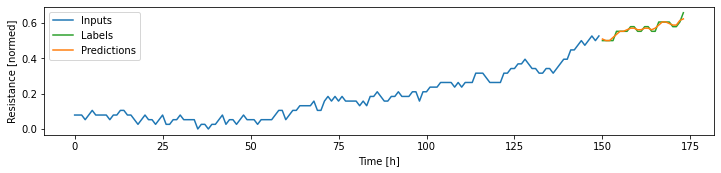

In [24]:
IPython.display.clear_output()

#multi_val_performance = model.evaluate(multi_window.val)
#multi_performance = model.evaluate(multi_window.test, verbose=0)
multi_window.plot(model)

In [25]:
test_df_test.shape()

TypeError: 'tuple' object is not callable

In [ ]:
pred = model.predict(test_df_test)